# Разработка модели

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

from fastai.vision import *

plt.ion()

# В этой части нужно загрузить датасет, разделить его на тренировочную и валидационную выборки и разложить картинки по папкам, чтобы в одной папке лежали картинки одного класса.

В качестве датасета был выбран датасет с породами собак: https://www.kaggle.com/jessicali9530/stanford-dogs-dataset

In [0]:
from google.colab import drive
drive.mount('drive')

In [0]:
!mkdir images
!cp drive/My\ Drive/dls_project/images.zip ./
!unzip images.zip

Разобьем картинки на тренировочную и тестовую части. Но не руками же это делать.

In [0]:
!pip install split-folders

Создадим новую папку для тренировочных данных.

In [0]:
!mkdir data

Разобъем данные.

In [0]:
import split_folders
split_folders.ratio(input='images', output="data", seed=1337, ratio=(.8, .2))

In [0]:
!ls data

train  val


Переименуем val в valid.

In [0]:
!mv data/val data/valid

In [0]:
from pathlib import Path
PATH = Path('./data/')
data = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(), bs=16, size=256)

# Теперь перейдем к созданию модели

В качестве модели используем Densenet201.

In [0]:
# если мы создаем предобученную модель, то все слои, кроме последних полносвязных будут заморожены,
# стоит помнить об этом при обучении
model = create_cnn(data, models.densenet201, metrics=accuracy)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/checkpoints/densenet201-c1103571.pth
100%|██████████| 81131730/81131730 [00:00<00:00, 83558947.47it/s]


# Осталось обучить модель и проверить ее точность.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


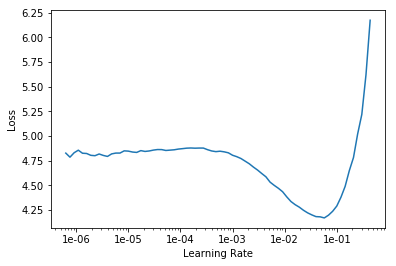

In [0]:
# Здесь мы используем lr_finder, чтобы выбрать скорость обучения
model.lr_find()
model.recorder.plot()

In [0]:
# Наилучший результат был получен при тренировке только последнего слоя.
# используем 1cycle policy подрбнее https://docs.fast.ai/callbacks.one_cycle.html
model.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.970728,1.499857,0.567296,03:32
1,1.281232,0.826443,0.750904,03:30
2,0.836078,0.623621,0.811169,03:31


In [0]:
model.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (5): ReLU(inplace)
   (6): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): ReLU(inplace)
   (9): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (10): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (11): ReLU(inplace)
   (12): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (14): ReLU(inplace)
   (15): Conv2d(128, 32, kernel_s

In [0]:
model.unfreeze()

In [0]:
model.fit_one_cycle(5, [5e-5, 5e-4, 5e-3])

epoch,train_loss,valid_loss,accuracy,time
0,1.587945,1.222495,0.648051,04:23
1,1.632826,1.481580,0.565287,04:22
2,1.178474,0.951279,0.718763,04:22
3,0.754362,0.681063,0.793090,04:22
4,0.502762,0.626296,0.807955,04:22


# Сохраним веса

In [0]:
model.export("export.pkl")

In [0]:
!cp ./data/export.pkl drive/My\ Drive/dls_project/model